In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import pandas as pd
%matplotlib inline
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import PIL
from PIL import Image, ImageFilter # to read images

In [3]:
# Connect to drive content
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive/"
anns_file_path = "/content/drive/My Drive/annotations.json"

# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [5]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)


# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Plastic film']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)
#
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000010.jpg,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
1,batch_1/000019.jpg,"[[354.0, 1268.0, 351.0, 1252.0, 347.0, 1237.0,...",98379.5,"[209.0, 920.0, 454.0, 562.0]",0,Clear plastic bottle
2,batch_1/000019.jpg,"[[1239.0, 841.0, 1247.0, 842.0, 1252.0, 835.0,...",43678.0,"[1212.0, 822.0, 179.0, 446.0]",0,Clear plastic bottle
3,batch_1/000001.jpg,"[[1062.0, 752.0, 1123.0, 744.0, 1153.0, 744.0,...",68667.0,"[826.0, 744.0, 464.0, 205.0]",0,Clear plastic bottle
4,batch_1/000005.jpg,"[[825.0, 731.0, 824.0, 670.0, 825.0, 649.0, 82...",17734.0,"[824.0, 557.0, 89.0, 236.0]",0,Clear plastic bottle


In [6]:
# New Dataframe with selective columns For cropping the images
df = final_merged_df[['filename','bbox','category']]
df = df.drop_duplicates('filename', keep='last')
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min'] 
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)

#Add padding to the bounding boxes
padding = 20
df['x_min'] = df['x_min'] - padding
df['y_min'] = df['y_min'] - padding
df['x_max'] = df['x_max'] + padding
df['y_max'] = df['y_max'] + padding
df.head()    

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000010.jpg,Clear plastic bottle,612,967,1152,1381
3,batch_1/000001.jpg,Clear plastic bottle,806,724,1310,969
4,batch_1/000005.jpg,Clear plastic bottle,804,537,933,813
5,batch_1/000048.jpg,Clear plastic bottle,559,501,921,1462
9,batch_1/000000.jpg,Clear plastic bottle,690,1205,883,1443


In [7]:
df.isnull().values.any()

False

In [8]:
# Save Initial data before augmentation to CSV file
df.to_csv(path +'InitialData.csv',index=False)

Create More data images

1. First cropped images and saved files in a new directory
2. Drop bbox column from dataframe 1
3. Read images from the new directory and create more images 
4. Save the copied image name in new pandas dataframe 2
5. Merge with dataframe 2 with 1.
6. Save the final df as csv file

In [9]:
# path of the folder containing the original images 
inPath = path+'data' 
# path of the folder that will contain the cropped image 
outPath = path+'trainDataTACO' 

In [10]:
# Reset Dataframe Index
df.reset_index(inplace = True , drop = True) 

# **Script for generating new images**

In [ ]:
# Create empty lists
new_filename = []
new_category = []
# Saved cropped images in a new directory
for ind in df.index:
  bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
  imagePath = os.path.join(inPath+'/'+df['filename'][ind])
  img = Image.open(imagePath)
  img = img.crop(bbox)
  img1 = img.rotate(88) # Rotated images at 88 degree
  img2 = img.filter(ImageFilter.GaussianBlur(radius = 2)) # Generate Blurred image 
  img3 = img.transpose(Image.FLIP_LEFT_RIGHT) #Flipping horizontally
  # Rename fileimages
  imageName = df['filename'][ind][:-4]
  # Cropped Image
  croppedImagePath = outPath +'/'+ imageName +'cropped'+'.jpg'
  new_filename.append(imageName +'cropped'+'.jpg')
  new_category.append(df['category'][ind])
  # Rotated Image
  rotatedImagePath = outPath +'/'+ imageName +'rotated'+'.jpg'
  new_filename.append(imageName +'rotated'+'.jpg')
  new_category.append(df['category'][ind])
  # Blurred Image
  blurImagePath = outPath +'/'+ imageName +'blur'+'.jpg'
  new_filename.append(imageName +'blur'+'.jpg')
  new_category.append(df['category'][ind])
  # Gray Scale Image
  hflipImagePath = outPath +'/'+ imageName +'hflip'+'.jpg'
  new_filename.append(imageName +'hflip'+'.jpg')
  new_category.append(df['category'][ind])
  # Saving files
  img.save(croppedImagePath)
  img1.save(rotatedImagePath)
  img2.save(blurImagePath)  
  img3.save(hflipImagePath)
  if ((df['category'][ind] == 'Drink can') or (df['category'][ind] == 'Plastic straw')): # For handling imabalanced class
    img4 = img.transpose(Image.FLIP_TOP_BOTTOM) 
    # Vertically Flip
    vflipImagePath = outPath +'/'+ imageName +'vflip'+'.jpg'
    new_filename.append(imageName +'vflip'+'.jpg')
    new_category.append(df['category'][ind])
    img4.save(vflipImagePath)

print("Images created successfully")

In [26]:
final_df = pd.DataFrame(columns=['category','filename'])
final_df['filename'] = new_filename
final_df['category'] = new_category
final_df

,category,filename
0,Clear plastic bottle,batch_1/000010cropped.jpg
1,Clear plastic bottle,batch_1/000010rotated.jpg
2,Clear plastic bottle,batch_1/000010blur.jpg
3,Clear plastic bottle,batch_1/000010hflip.jpg
4,Clear plastic bottle,batch_1/000001cropped.jpg
...,...,...
3437,Plastic straw,batch_9/000096cropped.jpg
3438,Plastic straw,batch_9/000096rotated.jpg
3439,Plastic straw,batch_9/000096blur.jpg
3440,Plastic straw,batch_9/000096hflip.jpg


In [27]:
# Save to CSV file
final_df.to_csv(path +'FinalData.csv',index=False)

In [28]:
axdf = pd.DataFrame(columns=['Classes', 'Count'])
axdf['Count'] = list(final_df['category'].value_counts())
axdf['Classes'] = final_df['category'].value_counts().index.values
axdf

,Classes,Count
0,Plastic film,1004
1,Cigarette,788
2,Drink can,560
3,Plastic straw,550
4,Clear plastic bottle,540


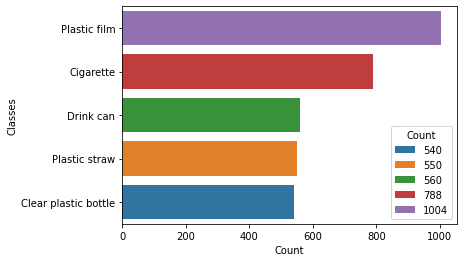

In [29]:
#Data Visual representation
sns.barplot(x = 'Count',y = 'Classes', data = axdf ,hue= axdf['Count'],dodge=False)